# Modeling and Performance

I will build 2 models here. The first one will be a lightgbm model for the dataframe we created in the feature creation notebook and the other one will be a naive model using the avg by weekday for the last 4 weeks for the data that contains items for which we do not have the entire history. This naive model can be replaced by a moving averge of any such model in a real scenario.

In [1]:
# import the data
import pandas as pd
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pickle
plt.rcParams['figure.figsize'] = (12, 5)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

#Pandas option
pd.options.display.float_format = '{:.2f}'.format

### Lightgbm model

A lightgbm is a good initial model to try out for this kind of problem as it is known to go beyond capturing trends and seasonaility like prophet or arima models. The lightgbm model can capture the dependencies between variuos features such as weather.

In [27]:
# Read in dataframe
df_model = pd.read_pickle('../data/df_model.pkl')

In [28]:
df_model.shape

(80504, 46)

For the lightgbm model cross-validation is important because unlike typical regression and classfication problems the cross validation needs to be done on successive time chunks and not at random. The training dates will be till 2 weeks before the max date. The next week will be used for validation and the last one as a holdout set for measuring model performance.

In [4]:
train_start_date = "2016-02-07"
train_end_date = "2017-12-16"
val_start_date = "2017-12-17"
val_end_date = "2017-12-23"
test_start_date = "2017-12-24"
test_end_date = "2017-12-31"

df_model = df_model.reset_index().set_index("Date")
df_model.drop('index', axis=1, inplace=True)

label_col = ["UnitSales"]
trainCols = df_model.columns[~df_model.columns.isin(label_col)]
X_train = df_model.loc[train_start_date:train_end_date][trainCols]
y_train = df_model.loc[train_start_date:train_end_date][label_col]

X_val = df_model.loc[val_start_date:val_end_date][trainCols]
y_val = df_model.loc[val_start_date:val_end_date][label_col]

X_test = df_model.loc[test_start_date:test_end_date][trainCols]
y_test = df_model.loc[test_start_date:test_end_date][label_col]

In [5]:
#define a 3-fold time-series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

# parameters for tuninig

param_dist = {
    "boosting_type": ["gbdt"],
    "objective": ["tweedie"],
    "tweedie_variance_power": [1.1],
    "n_estimators": [500],
    "metric": ["rmse"],
    "max_depth": [30, 50, 70],
    "num_leaves": [250, 500, 1000],
    "learning_rate": [0.03, 0.1],
    "feature_fraction": [0.5, 0.7],
    "bagging_fraction": [0.5, 0.7],
}

reg = lgb.LGBMRegressor()

n_iter_search = 5


In [6]:
random_search = RandomizedSearchCV(
    reg,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=tscv,
    scoring="neg_mean_squared_error",
    #n_jobs=-1,
)

# Train on the training portion of the CV
# Validated on the validation/test portion of the CV
# Early stopping using the test portion of the dataset

random_search.fit(
    X_train,
    y_train,
    eval_metric="rmse",
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=1,
)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[1]	valid_0's rmse: 4470.01	valid_1's rmse: 4526.36
[2]	valid_0's rmse: 4151.68	valid_1's rmse: 4235.37
[3]	valid_0's rmse: 3860.1	valid_1's rmse: 3997.32
[4]	valid_0's rmse: 3569.87	valid_1's rmse: 3766.51
[5]	valid_0's rmse: 3294.18	valid_1's rmse: 3566.74
[6]	valid_0's rmse: 3044.92	valid_1's rmse: 3406.21
[7]	valid_0's rmse: 2821.45	valid_1's rmse: 3242.52
[8]	valid_0's rmse: 2617.79	valid_1's rmse: 3111.68
[9]	valid_0's rmse: 2436.86	valid_1's rmse: 2971.18
[10]	valid_0's rmse: 2277.11	valid_1's rmse: 2858.67
[11]	valid_0's rmse: 2136.87	valid_1's rmse: 2769.34
[12]	valid_0's rmse: 2011.1	valid_1's rmse: 2692.24
[13]	valid_0's rmse: 1905.06	valid_1's rmse: 2637.08
[14]	valid_0's rmse: 1812.29	valid_1's rmse: 2577.87
[15]	valid_0's rmse: 1731.85

[155]	valid_0's rmse: 1221.14	valid_1's rmse: 2287.38
[156]	valid_0's rmse: 1221.17	valid_1's rmse: 2287.57
[157]	valid_0's rmse: 1221.12	valid_1's rmse: 2285.7
[158]	valid_0's rmse: 1221.2	valid_1's rmse: 2284.9
[159]	valid_0's rmse: 1221.26	valid_1's rmse: 2285.93
[160]	valid_0's rmse: 1221.16	valid_1's rmse: 2285.6
[161]	valid_0's rmse: 1221.16	valid_1's rmse: 2286.52
[162]	valid_0's rmse: 1221.12	valid_1's rmse: 2286.49
[163]	valid_0's rmse: 1221.05	valid_1's rmse: 2286.65
[164]	valid_0's rmse: 1221.01	valid_1's rmse: 2287.22
[165]	valid_0's rmse: 1220.97	valid_1's rmse: 2287.72
[166]	valid_0's rmse: 1220.91	valid_1's rmse: 2287.94
[167]	valid_0's rmse: 1221.05	valid_1's rmse: 2287.82
[168]	valid_0's rmse: 1221.09	valid_1's rmse: 2288.17
[169]	valid_0's rmse: 1221.13	valid_1's rmse: 2288.64
[170]	valid_0's rmse: 1221.15	valid_1's rmse: 2288.71
[171]	valid_0's rmse: 1221.24	valid_1's rmse: 2288.59
[172]	valid_0's rmse: 1221.16	valid_1's rmse: 2287.5
[173]	valid_0's rmse: 1221.23	val

[309]	valid_0's rmse: 1221.72	valid_1's rmse: 2288.49
[310]	valid_0's rmse: 1221.74	valid_1's rmse: 2288.39
[311]	valid_0's rmse: 1221.74	valid_1's rmse: 2288.18
[312]	valid_0's rmse: 1221.76	valid_1's rmse: 2288.28
[313]	valid_0's rmse: 1221.77	valid_1's rmse: 2288.31
[314]	valid_0's rmse: 1221.77	valid_1's rmse: 2288.4
[315]	valid_0's rmse: 1221.81	valid_1's rmse: 2288.34
[316]	valid_0's rmse: 1221.8	valid_1's rmse: 2288.34
[317]	valid_0's rmse: 1221.79	valid_1's rmse: 2288.14
[318]	valid_0's rmse: 1221.79	valid_1's rmse: 2288.06
[319]	valid_0's rmse: 1221.78	valid_1's rmse: 2288.06
[320]	valid_0's rmse: 1221.75	valid_1's rmse: 2288.13
[321]	valid_0's rmse: 1221.74	valid_1's rmse: 2288.14
[322]	valid_0's rmse: 1221.73	valid_1's rmse: 2288.19
[323]	valid_0's rmse: 1221.72	valid_1's rmse: 2288.23
[324]	valid_0's rmse: 1221.72	valid_1's rmse: 2288.3
[325]	valid_0's rmse: 1221.73	valid_1's rmse: 2288.03
[326]	valid_0's rmse: 1221.72	valid_1's rmse: 2288.16
[327]	valid_0's rmse: 1221.67	v

[468]	valid_0's rmse: 1221.76	valid_1's rmse: 2290.56
[469]	valid_0's rmse: 1221.75	valid_1's rmse: 2290.61
[470]	valid_0's rmse: 1221.76	valid_1's rmse: 2290.64
[471]	valid_0's rmse: 1221.76	valid_1's rmse: 2290.6
[472]	valid_0's rmse: 1221.76	valid_1's rmse: 2290.55
[473]	valid_0's rmse: 1221.76	valid_1's rmse: 2290.64
[474]	valid_0's rmse: 1221.78	valid_1's rmse: 2290.72
[475]	valid_0's rmse: 1221.79	valid_1's rmse: 2290.78
[476]	valid_0's rmse: 1221.79	valid_1's rmse: 2290.78
[477]	valid_0's rmse: 1221.8	valid_1's rmse: 2290.82
[478]	valid_0's rmse: 1221.8	valid_1's rmse: 2290.77
[479]	valid_0's rmse: 1221.8	valid_1's rmse: 2290.78
[480]	valid_0's rmse: 1221.82	valid_1's rmse: 2290.63
[481]	valid_0's rmse: 1221.86	valid_1's rmse: 2290.67
[482]	valid_0's rmse: 1221.86	valid_1's rmse: 2290.64
[483]	valid_0's rmse: 1221.86	valid_1's rmse: 2290.63
[484]	valid_0's rmse: 1221.87	valid_1's rmse: 2290.63
[485]	valid_0's rmse: 1221.86	valid_1's rmse: 2290.66
[486]	valid_0's rmse: 1221.85	va

[122]	valid_0's rmse: 956.219	valid_1's rmse: 2376.04
[123]	valid_0's rmse: 956.1	valid_1's rmse: 2375.94
[124]	valid_0's rmse: 956.348	valid_1's rmse: 2375.93
[125]	valid_0's rmse: 956.285	valid_1's rmse: 2374
[126]	valid_0's rmse: 956.168	valid_1's rmse: 2373.68
[127]	valid_0's rmse: 955.97	valid_1's rmse: 2373.43
[128]	valid_0's rmse: 955.669	valid_1's rmse: 2373.72
[129]	valid_0's rmse: 955.5	valid_1's rmse: 2373.67
[130]	valid_0's rmse: 955.425	valid_1's rmse: 2372.54
[131]	valid_0's rmse: 955.535	valid_1's rmse: 2371.77
[132]	valid_0's rmse: 955.575	valid_1's rmse: 2370.54
[133]	valid_0's rmse: 955.378	valid_1's rmse: 2371.51
[134]	valid_0's rmse: 955.385	valid_1's rmse: 2371.49
[135]	valid_0's rmse: 955.526	valid_1's rmse: 2371.93
[136]	valid_0's rmse: 955.476	valid_1's rmse: 2371.75
[137]	valid_0's rmse: 955.453	valid_1's rmse: 2371.41
[138]	valid_0's rmse: 955.34	valid_1's rmse: 2370.3
[139]	valid_0's rmse: 955.293	valid_1's rmse: 2370.97
[140]	valid_0's rmse: 955.256	valid_1'

[281]	valid_0's rmse: 956.994	valid_1's rmse: 2363.43
[282]	valid_0's rmse: 957.006	valid_1's rmse: 2363.43
[283]	valid_0's rmse: 956.964	valid_1's rmse: 2363.41
[284]	valid_0's rmse: 956.966	valid_1's rmse: 2363.4
[285]	valid_0's rmse: 957.003	valid_1's rmse: 2363.08
[286]	valid_0's rmse: 957.019	valid_1's rmse: 2363.31
[287]	valid_0's rmse: 956.965	valid_1's rmse: 2363.42
[288]	valid_0's rmse: 956.921	valid_1's rmse: 2363.37
[289]	valid_0's rmse: 956.912	valid_1's rmse: 2363.32
[290]	valid_0's rmse: 956.876	valid_1's rmse: 2363.28
[291]	valid_0's rmse: 956.873	valid_1's rmse: 2362.86
[292]	valid_0's rmse: 956.841	valid_1's rmse: 2362.73
[293]	valid_0's rmse: 956.815	valid_1's rmse: 2362.76
[294]	valid_0's rmse: 956.841	valid_1's rmse: 2362.76
[295]	valid_0's rmse: 956.931	valid_1's rmse: 2362.76
[296]	valid_0's rmse: 956.908	valid_1's rmse: 2362.81
[297]	valid_0's rmse: 956.922	valid_1's rmse: 2362.63
[298]	valid_0's rmse: 956.944	valid_1's rmse: 2362.65
[299]	valid_0's rmse: 956.931

[435]	valid_0's rmse: 957.779	valid_1's rmse: 2364.05
[436]	valid_0's rmse: 957.803	valid_1's rmse: 2364.03
[437]	valid_0's rmse: 957.798	valid_1's rmse: 2364.1
[438]	valid_0's rmse: 957.815	valid_1's rmse: 2364.22
[439]	valid_0's rmse: 957.801	valid_1's rmse: 2364.13
[440]	valid_0's rmse: 957.829	valid_1's rmse: 2364.13
[441]	valid_0's rmse: 957.836	valid_1's rmse: 2364.13
[442]	valid_0's rmse: 957.843	valid_1's rmse: 2364.13
[443]	valid_0's rmse: 957.839	valid_1's rmse: 2364.12
[444]	valid_0's rmse: 957.835	valid_1's rmse: 2364.12
[445]	valid_0's rmse: 957.843	valid_1's rmse: 2364.12
[446]	valid_0's rmse: 957.84	valid_1's rmse: 2364.11
[447]	valid_0's rmse: 957.847	valid_1's rmse: 2364.07
[448]	valid_0's rmse: 957.861	valid_1's rmse: 2364.16
[449]	valid_0's rmse: 957.887	valid_1's rmse: 2364.14
[450]	valid_0's rmse: 957.899	valid_1's rmse: 2364.16
[451]	valid_0's rmse: 957.903	valid_1's rmse: 2364.17
[452]	valid_0's rmse: 957.906	valid_1's rmse: 2364.19
[453]	valid_0's rmse: 957.907	

[89]	valid_0's rmse: 634.234	valid_1's rmse: 2755.27
[90]	valid_0's rmse: 634.183	valid_1's rmse: 2755.5
[91]	valid_0's rmse: 633.876	valid_1's rmse: 2755.9
[92]	valid_0's rmse: 633.366	valid_1's rmse: 2755.92
[93]	valid_0's rmse: 632.888	valid_1's rmse: 2754.21
[94]	valid_0's rmse: 632.99	valid_1's rmse: 2754.25
[95]	valid_0's rmse: 632.7	valid_1's rmse: 2754.2
[96]	valid_0's rmse: 632.734	valid_1's rmse: 2754.32
[97]	valid_0's rmse: 632.314	valid_1's rmse: 2753.87
[98]	valid_0's rmse: 632.216	valid_1's rmse: 2754.35
[99]	valid_0's rmse: 631.625	valid_1's rmse: 2753.81
[100]	valid_0's rmse: 631.62	valid_1's rmse: 2754.73
[101]	valid_0's rmse: 631.512	valid_1's rmse: 2755.95
[102]	valid_0's rmse: 631.341	valid_1's rmse: 2755.24
[103]	valid_0's rmse: 631.324	valid_1's rmse: 2755.29
[104]	valid_0's rmse: 630.696	valid_1's rmse: 2756.59
[105]	valid_0's rmse: 630.102	valid_1's rmse: 2756.59
[106]	valid_0's rmse: 629.945	valid_1's rmse: 2757.02
[107]	valid_0's rmse: 629.672	valid_1's rmse: 

[245]	valid_0's rmse: 622.261	valid_1's rmse: 2760.37
[246]	valid_0's rmse: 622.212	valid_1's rmse: 2760.63
[247]	valid_0's rmse: 622.224	valid_1's rmse: 2760.64
[248]	valid_0's rmse: 622.201	valid_1's rmse: 2760.87
[249]	valid_0's rmse: 622.158	valid_1's rmse: 2761.14
[250]	valid_0's rmse: 622.144	valid_1's rmse: 2761.13
[251]	valid_0's rmse: 622.195	valid_1's rmse: 2761.03
[252]	valid_0's rmse: 622.186	valid_1's rmse: 2760.97
[253]	valid_0's rmse: 622.147	valid_1's rmse: 2761.05
[254]	valid_0's rmse: 622.193	valid_1's rmse: 2761.08
[255]	valid_0's rmse: 622.037	valid_1's rmse: 2760.36
[256]	valid_0's rmse: 622.018	valid_1's rmse: 2760.69
[257]	valid_0's rmse: 622.026	valid_1's rmse: 2760.72
[258]	valid_0's rmse: 622.036	valid_1's rmse: 2760.72
[259]	valid_0's rmse: 622.019	valid_1's rmse: 2760.71
[260]	valid_0's rmse: 622	valid_1's rmse: 2760.56
[261]	valid_0's rmse: 622.001	valid_1's rmse: 2760.86
[262]	valid_0's rmse: 622.032	valid_1's rmse: 2760.75
[263]	valid_0's rmse: 622.012	va

[400]	valid_0's rmse: 621.109	valid_1's rmse: 2762.34
[401]	valid_0's rmse: 621.119	valid_1's rmse: 2762.34
[402]	valid_0's rmse: 621.123	valid_1's rmse: 2762.34
[403]	valid_0's rmse: 621.12	valid_1's rmse: 2762.23
[404]	valid_0's rmse: 621.163	valid_1's rmse: 2762.23
[405]	valid_0's rmse: 621.107	valid_1's rmse: 2762.1
[406]	valid_0's rmse: 621.142	valid_1's rmse: 2762.2
[407]	valid_0's rmse: 621.155	valid_1's rmse: 2762.33
[408]	valid_0's rmse: 621.164	valid_1's rmse: 2762.31
[409]	valid_0's rmse: 621.177	valid_1's rmse: 2762.31
[410]	valid_0's rmse: 621.177	valid_1's rmse: 2762.36
[411]	valid_0's rmse: 621.154	valid_1's rmse: 2762.38
[412]	valid_0's rmse: 621.147	valid_1's rmse: 2762.39
[413]	valid_0's rmse: 621.149	valid_1's rmse: 2762.37
[414]	valid_0's rmse: 621.163	valid_1's rmse: 2762.5
[415]	valid_0's rmse: 621.135	valid_1's rmse: 2762.41
[416]	valid_0's rmse: 621.124	valid_1's rmse: 2762.41
[417]	valid_0's rmse: 621.105	valid_1's rmse: 2762.37
[418]	valid_0's rmse: 621.144	va

[54]	valid_0's rmse: 1767.42	valid_1's rmse: 2564.29
[55]	valid_0's rmse: 1746.21	valid_1's rmse: 2553.65
[56]	valid_0's rmse: 1725.95	valid_1's rmse: 2544.77
[57]	valid_0's rmse: 1705.02	valid_1's rmse: 2531.53
[58]	valid_0's rmse: 1687.67	valid_1's rmse: 2528.19
[59]	valid_0's rmse: 1667.78	valid_1's rmse: 2515.33
[60]	valid_0's rmse: 1649.23	valid_1's rmse: 2503.16
[61]	valid_0's rmse: 1633.57	valid_1's rmse: 2499.6
[62]	valid_0's rmse: 1617.55	valid_1's rmse: 2493.25
[63]	valid_0's rmse: 1602.61	valid_1's rmse: 2486.62
[64]	valid_0's rmse: 1589.12	valid_1's rmse: 2482.21
[65]	valid_0's rmse: 1575.14	valid_1's rmse: 2480.02
[66]	valid_0's rmse: 1559.76	valid_1's rmse: 2470.93
[67]	valid_0's rmse: 1549.11	valid_1's rmse: 2467.7
[68]	valid_0's rmse: 1535.94	valid_1's rmse: 2460.68
[69]	valid_0's rmse: 1522.48	valid_1's rmse: 2455.54
[70]	valid_0's rmse: 1510.02	valid_1's rmse: 2447.91
[71]	valid_0's rmse: 1499.01	valid_1's rmse: 2443.57
[72]	valid_0's rmse: 1487.66	valid_1's rmse: 243

[212]	valid_0's rmse: 1222.31	valid_1's rmse: 2283.86
[213]	valid_0's rmse: 1222.03	valid_1's rmse: 2283.4
[214]	valid_0's rmse: 1221.31	valid_1's rmse: 2284.67
[215]	valid_0's rmse: 1221.09	valid_1's rmse: 2285.07
[216]	valid_0's rmse: 1221.17	valid_1's rmse: 2284.96
[217]	valid_0's rmse: 1221.1	valid_1's rmse: 2284.44
[218]	valid_0's rmse: 1220.95	valid_1's rmse: 2284.47
[219]	valid_0's rmse: 1220.28	valid_1's rmse: 2285.61
[220]	valid_0's rmse: 1220.38	valid_1's rmse: 2285.34
[221]	valid_0's rmse: 1220.27	valid_1's rmse: 2284.84
[222]	valid_0's rmse: 1219.54	valid_1's rmse: 2285.31
[223]	valid_0's rmse: 1219.43	valid_1's rmse: 2285.48
[224]	valid_0's rmse: 1219.26	valid_1's rmse: 2284.92
[225]	valid_0's rmse: 1218.8	valid_1's rmse: 2286.06
[226]	valid_0's rmse: 1218.58	valid_1's rmse: 2285.52
[227]	valid_0's rmse: 1218.53	valid_1's rmse: 2285.82
[228]	valid_0's rmse: 1218.51	valid_1's rmse: 2285.82
[229]	valid_0's rmse: 1218	valid_1's rmse: 2286.58
[230]	valid_0's rmse: 1217.93	vali

[368]	valid_0's rmse: 1207.74	valid_1's rmse: 2307.09
[369]	valid_0's rmse: 1207.73	valid_1's rmse: 2307.03
[370]	valid_0's rmse: 1207.67	valid_1's rmse: 2306.87
[371]	valid_0's rmse: 1207.69	valid_1's rmse: 2307.16
[372]	valid_0's rmse: 1207.73	valid_1's rmse: 2307.29
[373]	valid_0's rmse: 1207.68	valid_1's rmse: 2307.25
[374]	valid_0's rmse: 1207.62	valid_1's rmse: 2307.08
[375]	valid_0's rmse: 1207.66	valid_1's rmse: 2307.13
[376]	valid_0's rmse: 1207.66	valid_1's rmse: 2307.16
[377]	valid_0's rmse: 1207.68	valid_1's rmse: 2307.35
[378]	valid_0's rmse: 1207.59	valid_1's rmse: 2307.34
[379]	valid_0's rmse: 1207.51	valid_1's rmse: 2307.52
[380]	valid_0's rmse: 1207.59	valid_1's rmse: 2307.59
[381]	valid_0's rmse: 1207.59	valid_1's rmse: 2307.59
[382]	valid_0's rmse: 1207.62	valid_1's rmse: 2307.91
[383]	valid_0's rmse: 1207.59	valid_1's rmse: 2307.92
[384]	valid_0's rmse: 1207.58	valid_1's rmse: 2308.09
[385]	valid_0's rmse: 1207.51	valid_1's rmse: 2307.74
[386]	valid_0's rmse: 1207.4

[32]	valid_0's rmse: 2496.68	valid_1's rmse: 3034.97
[33]	valid_0's rmse: 2448.29	valid_1's rmse: 3003.96
[34]	valid_0's rmse: 2395.6	valid_1's rmse: 2974.22
[35]	valid_0's rmse: 2343.96	valid_1's rmse: 2941.36
[36]	valid_0's rmse: 2292.76	valid_1's rmse: 2899.26
[37]	valid_0's rmse: 2249.05	valid_1's rmse: 2881.79
[38]	valid_0's rmse: 2201.89	valid_1's rmse: 2849.11
[39]	valid_0's rmse: 2161.52	valid_1's rmse: 2825.04
[40]	valid_0's rmse: 2115.92	valid_1's rmse: 2795.13
[41]	valid_0's rmse: 2076.78	valid_1's rmse: 2774.7
[42]	valid_0's rmse: 2035.13	valid_1's rmse: 2748.68
[43]	valid_0's rmse: 1994.91	valid_1's rmse: 2723.76
[44]	valid_0's rmse: 1959.03	valid_1's rmse: 2703.67
[45]	valid_0's rmse: 1920.7	valid_1's rmse: 2678.61
[46]	valid_0's rmse: 1883.95	valid_1's rmse: 2656.88
[47]	valid_0's rmse: 1848.04	valid_1's rmse: 2633.56
[48]	valid_0's rmse: 1818.81	valid_1's rmse: 2615.21
[49]	valid_0's rmse: 1785.68	valid_1's rmse: 2595.36
[50]	valid_0's rmse: 1754.55	valid_1's rmse: 2575

[192]	valid_0's rmse: 967.687	valid_1's rmse: 2136.8
[193]	valid_0's rmse: 967.31	valid_1's rmse: 2136.01
[194]	valid_0's rmse: 966.625	valid_1's rmse: 2133.76
[195]	valid_0's rmse: 966.591	valid_1's rmse: 2134.02
[196]	valid_0's rmse: 966.341	valid_1's rmse: 2133.51
[197]	valid_0's rmse: 966.042	valid_1's rmse: 2133.1
[198]	valid_0's rmse: 965.873	valid_1's rmse: 2132.77
[199]	valid_0's rmse: 965.569	valid_1's rmse: 2131.79
[200]	valid_0's rmse: 965.313	valid_1's rmse: 2132.25
[201]	valid_0's rmse: 965.068	valid_1's rmse: 2131.77
[202]	valid_0's rmse: 964.829	valid_1's rmse: 2130.62
[203]	valid_0's rmse: 964.45	valid_1's rmse: 2130.04
[204]	valid_0's rmse: 964.297	valid_1's rmse: 2129.61
[205]	valid_0's rmse: 964.002	valid_1's rmse: 2130.3
[206]	valid_0's rmse: 963.621	valid_1's rmse: 2127.47
[207]	valid_0's rmse: 963.411	valid_1's rmse: 2127.02
[208]	valid_0's rmse: 962.946	valid_1's rmse: 2127.84
[209]	valid_0's rmse: 962.307	valid_1's rmse: 2128.26
[210]	valid_0's rmse: 961.989	val

[359]	valid_0's rmse: 943.421	valid_1's rmse: 2150.16
[360]	valid_0's rmse: 943.441	valid_1's rmse: 2150.19
[361]	valid_0's rmse: 943.481	valid_1's rmse: 2149.88
[362]	valid_0's rmse: 943.363	valid_1's rmse: 2149.9
[363]	valid_0's rmse: 943.236	valid_1's rmse: 2149.91
[364]	valid_0's rmse: 943.175	valid_1's rmse: 2149.63
[365]	valid_0's rmse: 943.091	valid_1's rmse: 2149.58
[366]	valid_0's rmse: 942.952	valid_1's rmse: 2149.65
[367]	valid_0's rmse: 942.839	valid_1's rmse: 2150.03
[368]	valid_0's rmse: 942.786	valid_1's rmse: 2149.99
[369]	valid_0's rmse: 942.887	valid_1's rmse: 2150.51
[370]	valid_0's rmse: 942.82	valid_1's rmse: 2150.64
[371]	valid_0's rmse: 942.772	valid_1's rmse: 2151.13
[372]	valid_0's rmse: 942.758	valid_1's rmse: 2150.91
[373]	valid_0's rmse: 942.719	valid_1's rmse: 2151.07
[374]	valid_0's rmse: 942.676	valid_1's rmse: 2151.06
[375]	valid_0's rmse: 942.571	valid_1's rmse: 2151.11
[376]	valid_0's rmse: 942.475	valid_1's rmse: 2151.12
[377]	valid_0's rmse: 942.407	

[16]	valid_0's rmse: 3434.22	valid_1's rmse: 3764.82
[17]	valid_0's rmse: 3350.7	valid_1's rmse: 3707.54
[18]	valid_0's rmse: 3273.45	valid_1's rmse: 3655.78
[19]	valid_0's rmse: 3194.18	valid_1's rmse: 3596.22
[20]	valid_0's rmse: 3121.89	valid_1's rmse: 3545.59
[21]	valid_0's rmse: 3051.82	valid_1's rmse: 3499.59
[22]	valid_0's rmse: 2981.28	valid_1's rmse: 3454.41
[23]	valid_0's rmse: 2912.79	valid_1's rmse: 3412.49
[24]	valid_0's rmse: 2840.99	valid_1's rmse: 3370.43
[25]	valid_0's rmse: 2776.05	valid_1's rmse: 3330.36
[26]	valid_0's rmse: 2713.06	valid_1's rmse: 3295.95
[27]	valid_0's rmse: 2667.9	valid_1's rmse: 3267.73
[28]	valid_0's rmse: 2604.07	valid_1's rmse: 3229.92
[29]	valid_0's rmse: 2545.6	valid_1's rmse: 3194.53
[30]	valid_0's rmse: 2487.12	valid_1's rmse: 3160.94
[31]	valid_0's rmse: 2426.26	valid_1's rmse: 3124.51
[32]	valid_0's rmse: 2371.5	valid_1's rmse: 3094.54
[33]	valid_0's rmse: 2318.39	valid_1's rmse: 3066.62
[34]	valid_0's rmse: 2263.9	valid_1's rmse: 3031.7

[176]	valid_0's rmse: 689.406	valid_1's rmse: 2411.04
[177]	valid_0's rmse: 688.656	valid_1's rmse: 2410.72
[178]	valid_0's rmse: 687.661	valid_1's rmse: 2409.18
[179]	valid_0's rmse: 686.785	valid_1's rmse: 2408.22
[180]	valid_0's rmse: 685.846	valid_1's rmse: 2407.54
[181]	valid_0's rmse: 685.07	valid_1's rmse: 2407.49
[182]	valid_0's rmse: 684.105	valid_1's rmse: 2408.05
[183]	valid_0's rmse: 683.478	valid_1's rmse: 2408.32
[184]	valid_0's rmse: 682.943	valid_1's rmse: 2408.89
[185]	valid_0's rmse: 682.427	valid_1's rmse: 2408.1
[186]	valid_0's rmse: 681.815	valid_1's rmse: 2411.67
[187]	valid_0's rmse: 681.302	valid_1's rmse: 2411.21
[188]	valid_0's rmse: 680.726	valid_1's rmse: 2410.51
[189]	valid_0's rmse: 680.043	valid_1's rmse: 2410.36
[190]	valid_0's rmse: 679.414	valid_1's rmse: 2410.35
[191]	valid_0's rmse: 679.039	valid_1's rmse: 2409.94
[192]	valid_0's rmse: 678.318	valid_1's rmse: 2409.74
[193]	valid_0's rmse: 677.86	valid_1's rmse: 2409.11
[194]	valid_0's rmse: 677.227	v

[337]	valid_0's rmse: 627.859	valid_1's rmse: 2401.89
[338]	valid_0's rmse: 627.588	valid_1's rmse: 2402.07
[339]	valid_0's rmse: 627.507	valid_1's rmse: 2402.73
[340]	valid_0's rmse: 627.463	valid_1's rmse: 2402.2
[341]	valid_0's rmse: 627.241	valid_1's rmse: 2402.4
[342]	valid_0's rmse: 627.116	valid_1's rmse: 2401.03
[343]	valid_0's rmse: 626.977	valid_1's rmse: 2401.04
[344]	valid_0's rmse: 626.8	valid_1's rmse: 2401.08
[345]	valid_0's rmse: 626.728	valid_1's rmse: 2401.01
[346]	valid_0's rmse: 626.542	valid_1's rmse: 2400.97
[347]	valid_0's rmse: 626.585	valid_1's rmse: 2400.95
[348]	valid_0's rmse: 626.516	valid_1's rmse: 2400.96
[349]	valid_0's rmse: 626.5	valid_1's rmse: 2400.88
[350]	valid_0's rmse: 626.455	valid_1's rmse: 2400.84
[351]	valid_0's rmse: 626.317	valid_1's rmse: 2400.22
[352]	valid_0's rmse: 626.239	valid_1's rmse: 2400.25
[353]	valid_0's rmse: 625.972	valid_1's rmse: 2399.78
[354]	valid_0's rmse: 625.786	valid_1's rmse: 2399.77
[355]	valid_0's rmse: 625.496	vali

[490]	valid_0's rmse: 611.343	valid_1's rmse: 2403.72
[491]	valid_0's rmse: 611.18	valid_1's rmse: 2403.48
[492]	valid_0's rmse: 610.943	valid_1's rmse: 2403.88
[493]	valid_0's rmse: 610.801	valid_1's rmse: 2403.38
[494]	valid_0's rmse: 610.804	valid_1's rmse: 2403.12
[495]	valid_0's rmse: 610.751	valid_1's rmse: 2403.02
[496]	valid_0's rmse: 610.736	valid_1's rmse: 2403
[497]	valid_0's rmse: 610.687	valid_1's rmse: 2403.01
[498]	valid_0's rmse: 610.687	valid_1's rmse: 2403.01
[499]	valid_0's rmse: 610.681	valid_1's rmse: 2402.99
[500]	valid_0's rmse: 610.687	valid_1's rmse: 2402.97
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[1]	valid_0's rmse: 4694.8	valid_1's rmse: 4724.1
[2]	valid_0's rmse: 4610.93	valid_1's rmse: 4640.99
[3]	valid_0's rmse: 4526.64	valid_1's rmse: 4569.84
[4]	valid_0's r

[153]	valid_0's rmse: 1275.41	valid_1's rmse: 2424.25
[154]	valid_0's rmse: 1275.2	valid_1's rmse: 2422.07
[155]	valid_0's rmse: 1274.76	valid_1's rmse: 2421.47
[156]	valid_0's rmse: 1274.52	valid_1's rmse: 2421.34
[157]	valid_0's rmse: 1274.12	valid_1's rmse: 2421.23
[158]	valid_0's rmse: 1274.07	valid_1's rmse: 2421.85
[159]	valid_0's rmse: 1273.59	valid_1's rmse: 2422.7
[160]	valid_0's rmse: 1273.43	valid_1's rmse: 2422
[161]	valid_0's rmse: 1272.79	valid_1's rmse: 2421.16
[162]	valid_0's rmse: 1272.48	valid_1's rmse: 2421.76
[163]	valid_0's rmse: 1272.19	valid_1's rmse: 2421.88
[164]	valid_0's rmse: 1271.97	valid_1's rmse: 2419.96
[165]	valid_0's rmse: 1271.72	valid_1's rmse: 2419.85
[166]	valid_0's rmse: 1271.47	valid_1's rmse: 2419.84
[167]	valid_0's rmse: 1271.1	valid_1's rmse: 2420.45
[168]	valid_0's rmse: 1270.81	valid_1's rmse: 2420.12
[169]	valid_0's rmse: 1270.46	valid_1's rmse: 2419.3
[170]	valid_0's rmse: 1270.19	valid_1's rmse: 2418.41
[171]	valid_0's rmse: 1270.06	valid

[318]	valid_0's rmse: 1256.98	valid_1's rmse: 2444.87
[319]	valid_0's rmse: 1256.99	valid_1's rmse: 2444.52
[320]	valid_0's rmse: 1256.93	valid_1's rmse: 2443.8
[321]	valid_0's rmse: 1256.97	valid_1's rmse: 2444.03
[322]	valid_0's rmse: 1256.97	valid_1's rmse: 2444.01
[323]	valid_0's rmse: 1256.91	valid_1's rmse: 2443.98
[324]	valid_0's rmse: 1256.98	valid_1's rmse: 2443.97
[325]	valid_0's rmse: 1256.87	valid_1's rmse: 2443.85
[326]	valid_0's rmse: 1256.81	valid_1's rmse: 2442.34
[327]	valid_0's rmse: 1256.86	valid_1's rmse: 2442.39
[328]	valid_0's rmse: 1256.85	valid_1's rmse: 2442.69
[329]	valid_0's rmse: 1256.92	valid_1's rmse: 2442.71
[330]	valid_0's rmse: 1256.86	valid_1's rmse: 2442.46
[331]	valid_0's rmse: 1256.72	valid_1's rmse: 2441.83
[332]	valid_0's rmse: 1256.63	valid_1's rmse: 2442.25
[333]	valid_0's rmse: 1256.72	valid_1's rmse: 2442.51
[334]	valid_0's rmse: 1256.79	valid_1's rmse: 2442.64
[335]	valid_0's rmse: 1256.77	valid_1's rmse: 2442.58
[336]	valid_0's rmse: 1256.76

[484]	valid_0's rmse: 1256.74	valid_1's rmse: 2430.67
[485]	valid_0's rmse: 1256.72	valid_1's rmse: 2430.53
[486]	valid_0's rmse: 1256.74	valid_1's rmse: 2430.59
[487]	valid_0's rmse: 1256.7	valid_1's rmse: 2431.04
[488]	valid_0's rmse: 1256.69	valid_1's rmse: 2431.21
[489]	valid_0's rmse: 1256.68	valid_1's rmse: 2431.2
[490]	valid_0's rmse: 1256.7	valid_1's rmse: 2431.21
[491]	valid_0's rmse: 1256.73	valid_1's rmse: 2430.86
[492]	valid_0's rmse: 1256.7	valid_1's rmse: 2430.21
[493]	valid_0's rmse: 1256.65	valid_1's rmse: 2430.09
[494]	valid_0's rmse: 1256.63	valid_1's rmse: 2430.33
[495]	valid_0's rmse: 1256.68	valid_1's rmse: 2429.62
[496]	valid_0's rmse: 1256.7	valid_1's rmse: 2429.64
[497]	valid_0's rmse: 1256.71	valid_1's rmse: 2429.64
[498]	valid_0's rmse: 1256.73	valid_1's rmse: 2429.63
[499]	valid_0's rmse: 1256.75	valid_1's rmse: 2429.71
[500]	valid_0's rmse: 1256.81	valid_1's rmse: 2428.86
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Curren

[148]	valid_0's rmse: 957.067	valid_1's rmse: 2257.24
[149]	valid_0's rmse: 956.09	valid_1's rmse: 2256.69
[150]	valid_0's rmse: 955.412	valid_1's rmse: 2256.15
[151]	valid_0's rmse: 955.049	valid_1's rmse: 2258.56
[152]	valid_0's rmse: 954.118	valid_1's rmse: 2258.1
[153]	valid_0's rmse: 953.632	valid_1's rmse: 2256.73
[154]	valid_0's rmse: 953.069	valid_1's rmse: 2255.75
[155]	valid_0's rmse: 952.798	valid_1's rmse: 2254.16
[156]	valid_0's rmse: 952.083	valid_1's rmse: 2255.12
[157]	valid_0's rmse: 951.248	valid_1's rmse: 2254.63
[158]	valid_0's rmse: 950.937	valid_1's rmse: 2254.36
[159]	valid_0's rmse: 950.595	valid_1's rmse: 2255.43
[160]	valid_0's rmse: 949.907	valid_1's rmse: 2257.53
[161]	valid_0's rmse: 949.719	valid_1's rmse: 2259.25
[162]	valid_0's rmse: 949.094	valid_1's rmse: 2258.9
[163]	valid_0's rmse: 948.506	valid_1's rmse: 2258.2
[164]	valid_0's rmse: 948.205	valid_1's rmse: 2257.73
[165]	valid_0's rmse: 947.751	valid_1's rmse: 2269.05
[166]	valid_0's rmse: 947.397	va

[312]	valid_0's rmse: 917.284	valid_1's rmse: 2283.9
[313]	valid_0's rmse: 917.065	valid_1's rmse: 2283.99
[314]	valid_0's rmse: 916.957	valid_1's rmse: 2284.42
[315]	valid_0's rmse: 916.828	valid_1's rmse: 2285.17
[316]	valid_0's rmse: 916.62	valid_1's rmse: 2285.19
[317]	valid_0's rmse: 916.739	valid_1's rmse: 2285.26
[318]	valid_0's rmse: 916.662	valid_1's rmse: 2285.17
[319]	valid_0's rmse: 916.665	valid_1's rmse: 2285.21
[320]	valid_0's rmse: 916.405	valid_1's rmse: 2285.66
[321]	valid_0's rmse: 916.243	valid_1's rmse: 2285.72
[322]	valid_0's rmse: 916.02	valid_1's rmse: 2285.46
[323]	valid_0's rmse: 916.245	valid_1's rmse: 2285.16
[324]	valid_0's rmse: 916.176	valid_1's rmse: 2285.09
[325]	valid_0's rmse: 916.089	valid_1's rmse: 2284.79
[326]	valid_0's rmse: 915.883	valid_1's rmse: 2284.36
[327]	valid_0's rmse: 915.745	valid_1's rmse: 2284.26
[328]	valid_0's rmse: 915.669	valid_1's rmse: 2283.96
[329]	valid_0's rmse: 915.593	valid_1's rmse: 2282.97
[330]	valid_0's rmse: 915.473	v

[476]	valid_0's rmse: 912.032	valid_1's rmse: 2294.32
[477]	valid_0's rmse: 912.104	valid_1's rmse: 2294.27
[478]	valid_0's rmse: 912.13	valid_1's rmse: 2294.32
[479]	valid_0's rmse: 912.079	valid_1's rmse: 2294.42
[480]	valid_0's rmse: 912.039	valid_1's rmse: 2295.65
[481]	valid_0's rmse: 911.928	valid_1's rmse: 2295.71
[482]	valid_0's rmse: 912.042	valid_1's rmse: 2295.7
[483]	valid_0's rmse: 912.05	valid_1's rmse: 2295.69
[484]	valid_0's rmse: 912.016	valid_1's rmse: 2295.67
[485]	valid_0's rmse: 912.038	valid_1's rmse: 2295.65
[486]	valid_0's rmse: 912.131	valid_1's rmse: 2295.6
[487]	valid_0's rmse: 911.943	valid_1's rmse: 2295.46
[488]	valid_0's rmse: 911.932	valid_1's rmse: 2295.38
[489]	valid_0's rmse: 911.93	valid_1's rmse: 2295.39
[490]	valid_0's rmse: 911.844	valid_1's rmse: 2295.88
[491]	valid_0's rmse: 911.83	valid_1's rmse: 2295.85
[492]	valid_0's rmse: 911.876	valid_1's rmse: 2295.85
[493]	valid_0's rmse: 911.936	valid_1's rmse: 2295.85
[494]	valid_0's rmse: 911.931	vali

[135]	valid_0's rmse: 746.822	valid_1's rmse: 2431.57
[136]	valid_0's rmse: 745.371	valid_1's rmse: 2431.06
[137]	valid_0's rmse: 744.235	valid_1's rmse: 2431.76
[138]	valid_0's rmse: 742.794	valid_1's rmse: 2432.47
[139]	valid_0's rmse: 741.793	valid_1's rmse: 2429.64
[140]	valid_0's rmse: 740.708	valid_1's rmse: 2429.15
[141]	valid_0's rmse: 739.581	valid_1's rmse: 2428.88
[142]	valid_0's rmse: 738.534	valid_1's rmse: 2429.28
[143]	valid_0's rmse: 737.75	valid_1's rmse: 2429.03
[144]	valid_0's rmse: 736.523	valid_1's rmse: 2427.41
[145]	valid_0's rmse: 735.383	valid_1's rmse: 2428.05
[146]	valid_0's rmse: 734.295	valid_1's rmse: 2428.35
[147]	valid_0's rmse: 733.573	valid_1's rmse: 2427.96
[148]	valid_0's rmse: 732.586	valid_1's rmse: 2428.74
[149]	valid_0's rmse: 731.18	valid_1's rmse: 2429.3
[150]	valid_0's rmse: 730.222	valid_1's rmse: 2430.01
[151]	valid_0's rmse: 729.583	valid_1's rmse: 2432.02
[152]	valid_0's rmse: 728.783	valid_1's rmse: 2431.37
[153]	valid_0's rmse: 727.836	v

[293]	valid_0's rmse: 669.007	valid_1's rmse: 2465.48
[294]	valid_0's rmse: 668.611	valid_1's rmse: 2466.68
[295]	valid_0's rmse: 668.545	valid_1's rmse: 2466.89
[296]	valid_0's rmse: 668.502	valid_1's rmse: 2466.93
[297]	valid_0's rmse: 668.16	valid_1's rmse: 2470.51
[298]	valid_0's rmse: 667.953	valid_1's rmse: 2470.4
[299]	valid_0's rmse: 667.666	valid_1's rmse: 2471.36
[300]	valid_0's rmse: 667.323	valid_1's rmse: 2472.16
[301]	valid_0's rmse: 667.191	valid_1's rmse: 2472.35
[302]	valid_0's rmse: 667.148	valid_1's rmse: 2472.32
[303]	valid_0's rmse: 666.796	valid_1's rmse: 2472.92
[304]	valid_0's rmse: 666.477	valid_1's rmse: 2472.43
[305]	valid_0's rmse: 666.385	valid_1's rmse: 2473.18
[306]	valid_0's rmse: 666.063	valid_1's rmse: 2472.39
[307]	valid_0's rmse: 665.951	valid_1's rmse: 2472.38
[308]	valid_0's rmse: 665.693	valid_1's rmse: 2473.64
[309]	valid_0's rmse: 665.458	valid_1's rmse: 2473.06
[310]	valid_0's rmse: 665.228	valid_1's rmse: 2473.06
[311]	valid_0's rmse: 665.135	

[456]	valid_0's rmse: 644.718	valid_1's rmse: 2481.75
[457]	valid_0's rmse: 644.552	valid_1's rmse: 2481.14
[458]	valid_0's rmse: 644.471	valid_1's rmse: 2481.13
[459]	valid_0's rmse: 644.303	valid_1's rmse: 2480.9
[460]	valid_0's rmse: 644.027	valid_1's rmse: 2480.81
[461]	valid_0's rmse: 643.936	valid_1's rmse: 2481.92
[462]	valid_0's rmse: 643.994	valid_1's rmse: 2483.29
[463]	valid_0's rmse: 643.971	valid_1's rmse: 2483.3
[464]	valid_0's rmse: 643.867	valid_1's rmse: 2483.3
[465]	valid_0's rmse: 643.767	valid_1's rmse: 2483.15
[466]	valid_0's rmse: 643.595	valid_1's rmse: 2482.91
[467]	valid_0's rmse: 643.578	valid_1's rmse: 2482.9
[468]	valid_0's rmse: 643.475	valid_1's rmse: 2482.89
[469]	valid_0's rmse: 643.395	valid_1's rmse: 2483.27
[470]	valid_0's rmse: 643.559	valid_1's rmse: 2483.27
[471]	valid_0's rmse: 643.252	valid_1's rmse: 2483.1
[472]	valid_0's rmse: 643.24	valid_1's rmse: 2483.09
[473]	valid_0's rmse: 643.149	valid_1's rmse: 2483.09
[474]	valid_0's rmse: 643.098	vali

[107]	valid_0's rmse: 1271.77	valid_1's rmse: 2445.1
[108]	valid_0's rmse: 1271.74	valid_1's rmse: 2446.15
[109]	valid_0's rmse: 1271.58	valid_1's rmse: 2446.82
[110]	valid_0's rmse: 1271.76	valid_1's rmse: 2445.49
[111]	valid_0's rmse: 1271.6	valid_1's rmse: 2446.63
[112]	valid_0's rmse: 1271.43	valid_1's rmse: 2446.77
[113]	valid_0's rmse: 1271.25	valid_1's rmse: 2446.19
[114]	valid_0's rmse: 1271.28	valid_1's rmse: 2444.83
[115]	valid_0's rmse: 1271.33	valid_1's rmse: 2444.47
[116]	valid_0's rmse: 1271.15	valid_1's rmse: 2444.17
[117]	valid_0's rmse: 1271.1	valid_1's rmse: 2444.66
[118]	valid_0's rmse: 1271.14	valid_1's rmse: 2443.96
[119]	valid_0's rmse: 1270.86	valid_1's rmse: 2444.35
[120]	valid_0's rmse: 1270.96	valid_1's rmse: 2443.54
[121]	valid_0's rmse: 1271	valid_1's rmse: 2443.78
[122]	valid_0's rmse: 1271	valid_1's rmse: 2443.02
[123]	valid_0's rmse: 1271.03	valid_1's rmse: 2442.74
[124]	valid_0's rmse: 1270.97	valid_1's rmse: 2441.25
[125]	valid_0's rmse: 1270.84	valid_1

[266]	valid_0's rmse: 1271.75	valid_1's rmse: 2444.95
[267]	valid_0's rmse: 1271.75	valid_1's rmse: 2444.95
[268]	valid_0's rmse: 1271.76	valid_1's rmse: 2445.03
[269]	valid_0's rmse: 1271.78	valid_1's rmse: 2445
[270]	valid_0's rmse: 1271.79	valid_1's rmse: 2444.77
[271]	valid_0's rmse: 1271.81	valid_1's rmse: 2444.66
[272]	valid_0's rmse: 1271.81	valid_1's rmse: 2444.83
[273]	valid_0's rmse: 1271.79	valid_1's rmse: 2444.88
[274]	valid_0's rmse: 1271.78	valid_1's rmse: 2444.79
[275]	valid_0's rmse: 1271.75	valid_1's rmse: 2444.79
[276]	valid_0's rmse: 1271.77	valid_1's rmse: 2444.78
[277]	valid_0's rmse: 1271.8	valid_1's rmse: 2444.48
[278]	valid_0's rmse: 1271.95	valid_1's rmse: 2444.44
[279]	valid_0's rmse: 1271.95	valid_1's rmse: 2444.04
[280]	valid_0's rmse: 1271.9	valid_1's rmse: 2444.16
[281]	valid_0's rmse: 1271.91	valid_1's rmse: 2443.75
[282]	valid_0's rmse: 1271.91	valid_1's rmse: 2443.85
[283]	valid_0's rmse: 1271.92	valid_1's rmse: 2443.89
[284]	valid_0's rmse: 1271.94	val

[428]	valid_0's rmse: 1272.51	valid_1's rmse: 2442.69
[429]	valid_0's rmse: 1272.49	valid_1's rmse: 2442.7
[430]	valid_0's rmse: 1272.5	valid_1's rmse: 2442.74
[431]	valid_0's rmse: 1272.53	valid_1's rmse: 2442.73
[432]	valid_0's rmse: 1272.5	valid_1's rmse: 2442.74
[433]	valid_0's rmse: 1272.5	valid_1's rmse: 2442.76
[434]	valid_0's rmse: 1272.53	valid_1's rmse: 2442.93
[435]	valid_0's rmse: 1272.53	valid_1's rmse: 2442.94
[436]	valid_0's rmse: 1272.52	valid_1's rmse: 2443.03
[437]	valid_0's rmse: 1272.52	valid_1's rmse: 2443.04
[438]	valid_0's rmse: 1272.5	valid_1's rmse: 2443.13
[439]	valid_0's rmse: 1272.51	valid_1's rmse: 2443.22
[440]	valid_0's rmse: 1272.5	valid_1's rmse: 2443.14
[441]	valid_0's rmse: 1272.54	valid_1's rmse: 2443.27
[442]	valid_0's rmse: 1272.53	valid_1's rmse: 2443.3
[443]	valid_0's rmse: 1272.55	valid_1's rmse: 2443.22
[444]	valid_0's rmse: 1272.55	valid_1's rmse: 2443.22
[445]	valid_0's rmse: 1272.57	valid_1's rmse: 2443.04
[446]	valid_0's rmse: 1272.55	valid

[87]	valid_0's rmse: 994.301	valid_1's rmse: 2292.01
[88]	valid_0's rmse: 993.965	valid_1's rmse: 2295.45
[89]	valid_0's rmse: 993.555	valid_1's rmse: 2293.9
[90]	valid_0's rmse: 993.323	valid_1's rmse: 2296.57
[91]	valid_0's rmse: 993.148	valid_1's rmse: 2295.7
[92]	valid_0's rmse: 992.847	valid_1's rmse: 2297.09
[93]	valid_0's rmse: 992.413	valid_1's rmse: 2299.44
[94]	valid_0's rmse: 992.764	valid_1's rmse: 2300.2
[95]	valid_0's rmse: 992.344	valid_1's rmse: 2299.71
[96]	valid_0's rmse: 991.807	valid_1's rmse: 2299.66
[97]	valid_0's rmse: 991.475	valid_1's rmse: 2300.04
[98]	valid_0's rmse: 991.368	valid_1's rmse: 2300.17
[99]	valid_0's rmse: 991.548	valid_1's rmse: 2299.87
[100]	valid_0's rmse: 991.267	valid_1's rmse: 2299.15
[101]	valid_0's rmse: 991.18	valid_1's rmse: 2297.97
[102]	valid_0's rmse: 990.897	valid_1's rmse: 2297.53
[103]	valid_0's rmse: 990.915	valid_1's rmse: 2297.78
[104]	valid_0's rmse: 991.029	valid_1's rmse: 2300.96
[105]	valid_0's rmse: 991.322	valid_1's rmse:

[252]	valid_0's rmse: 986.082	valid_1's rmse: 2297.61
[253]	valid_0's rmse: 986.126	valid_1's rmse: 2296.96
[254]	valid_0's rmse: 985.923	valid_1's rmse: 2296.11
[255]	valid_0's rmse: 985.918	valid_1's rmse: 2296.13
[256]	valid_0's rmse: 985.89	valid_1's rmse: 2297.34
[257]	valid_0's rmse: 985.951	valid_1's rmse: 2297.2
[258]	valid_0's rmse: 985.98	valid_1's rmse: 2297.27
[259]	valid_0's rmse: 985.948	valid_1's rmse: 2296.46
[260]	valid_0's rmse: 985.921	valid_1's rmse: 2296.64
[261]	valid_0's rmse: 985.867	valid_1's rmse: 2296.91
[262]	valid_0's rmse: 985.854	valid_1's rmse: 2296.79
[263]	valid_0's rmse: 985.863	valid_1's rmse: 2296.79
[264]	valid_0's rmse: 985.839	valid_1's rmse: 2296.97
[265]	valid_0's rmse: 985.8	valid_1's rmse: 2297.14
[266]	valid_0's rmse: 985.688	valid_1's rmse: 2297.15
[267]	valid_0's rmse: 985.523	valid_1's rmse: 2296.87
[268]	valid_0's rmse: 985.396	valid_1's rmse: 2297.04
[269]	valid_0's rmse: 985.285	valid_1's rmse: 2296.96
[270]	valid_0's rmse: 985.281	val

[409]	valid_0's rmse: 984.748	valid_1's rmse: 2291.6
[410]	valid_0's rmse: 984.773	valid_1's rmse: 2291.6
[411]	valid_0's rmse: 984.827	valid_1's rmse: 2291.35
[412]	valid_0's rmse: 984.823	valid_1's rmse: 2291.46
[413]	valid_0's rmse: 984.813	valid_1's rmse: 2291.52
[414]	valid_0's rmse: 984.8	valid_1's rmse: 2291.78
[415]	valid_0's rmse: 984.781	valid_1's rmse: 2291.78
[416]	valid_0's rmse: 984.851	valid_1's rmse: 2291.86
[417]	valid_0's rmse: 984.806	valid_1's rmse: 2291.73
[418]	valid_0's rmse: 984.765	valid_1's rmse: 2291.85
[419]	valid_0's rmse: 984.744	valid_1's rmse: 2291.38
[420]	valid_0's rmse: 984.698	valid_1's rmse: 2291.3
[421]	valid_0's rmse: 984.752	valid_1's rmse: 2291.3
[422]	valid_0's rmse: 984.752	valid_1's rmse: 2291.27
[423]	valid_0's rmse: 984.754	valid_1's rmse: 2291.27
[424]	valid_0's rmse: 984.727	valid_1's rmse: 2291.2
[425]	valid_0's rmse: 984.745	valid_1's rmse: 2291.48
[426]	valid_0's rmse: 984.725	valid_1's rmse: 2291.51
[427]	valid_0's rmse: 984.801	valid

[67]	valid_0's rmse: 697.687	valid_1's rmse: 2496.26
[68]	valid_0's rmse: 696.644	valid_1's rmse: 2498.26
[69]	valid_0's rmse: 695.396	valid_1's rmse: 2497.16
[70]	valid_0's rmse: 694.393	valid_1's rmse: 2491.06
[71]	valid_0's rmse: 692.608	valid_1's rmse: 2490.22
[72]	valid_0's rmse: 692.474	valid_1's rmse: 2490.28
[73]	valid_0's rmse: 691.152	valid_1's rmse: 2489.73
[74]	valid_0's rmse: 689.725	valid_1's rmse: 2490.04
[75]	valid_0's rmse: 688.789	valid_1's rmse: 2489.79
[76]	valid_0's rmse: 688.034	valid_1's rmse: 2492.47
[77]	valid_0's rmse: 686.299	valid_1's rmse: 2492.67
[78]	valid_0's rmse: 684.651	valid_1's rmse: 2492.08
[79]	valid_0's rmse: 683.724	valid_1's rmse: 2493.71
[80]	valid_0's rmse: 682.952	valid_1's rmse: 2495.85
[81]	valid_0's rmse: 683.047	valid_1's rmse: 2495.65
[82]	valid_0's rmse: 681.947	valid_1's rmse: 2495.55
[83]	valid_0's rmse: 681.389	valid_1's rmse: 2492.84
[84]	valid_0's rmse: 681.297	valid_1's rmse: 2492.8
[85]	valid_0's rmse: 680.636	valid_1's rmse: 24

[224]	valid_0's rmse: 644.622	valid_1's rmse: 2503.66
[225]	valid_0's rmse: 644.535	valid_1's rmse: 2503.71
[226]	valid_0's rmse: 644.39	valid_1's rmse: 2503.69
[227]	valid_0's rmse: 644.385	valid_1's rmse: 2503.7
[228]	valid_0's rmse: 644.454	valid_1's rmse: 2503.58
[229]	valid_0's rmse: 644.483	valid_1's rmse: 2503.58
[230]	valid_0's rmse: 644.483	valid_1's rmse: 2503.58
[231]	valid_0's rmse: 644.526	valid_1's rmse: 2503.55
[232]	valid_0's rmse: 644.575	valid_1's rmse: 2503.53
[233]	valid_0's rmse: 644.504	valid_1's rmse: 2503.94
[234]	valid_0's rmse: 644.36	valid_1's rmse: 2504.24
[235]	valid_0's rmse: 644.359	valid_1's rmse: 2503.99
[236]	valid_0's rmse: 644.052	valid_1's rmse: 2504.01
[237]	valid_0's rmse: 644.168	valid_1's rmse: 2504.47
[238]	valid_0's rmse: 644.18	valid_1's rmse: 2504.5
[239]	valid_0's rmse: 644.178	valid_1's rmse: 2504.43
[240]	valid_0's rmse: 644.081	valid_1's rmse: 2504.35
[241]	valid_0's rmse: 643.704	valid_1's rmse: 2504.75
[242]	valid_0's rmse: 643.693	val

[385]	valid_0's rmse: 639.63	valid_1's rmse: 2501.35
[386]	valid_0's rmse: 639.656	valid_1's rmse: 2501.34
[387]	valid_0's rmse: 639.671	valid_1's rmse: 2501.35
[388]	valid_0's rmse: 639.785	valid_1's rmse: 2501.36
[389]	valid_0's rmse: 639.779	valid_1's rmse: 2501.35
[390]	valid_0's rmse: 639.796	valid_1's rmse: 2501.38
[391]	valid_0's rmse: 639.893	valid_1's rmse: 2501.18
[392]	valid_0's rmse: 639.869	valid_1's rmse: 2501.1
[393]	valid_0's rmse: 639.894	valid_1's rmse: 2501.05
[394]	valid_0's rmse: 640.009	valid_1's rmse: 2501.32
[395]	valid_0's rmse: 639.978	valid_1's rmse: 2501.29
[396]	valid_0's rmse: 640.052	valid_1's rmse: 2501.33
[397]	valid_0's rmse: 640.068	valid_1's rmse: 2501.33
[398]	valid_0's rmse: 640.069	valid_1's rmse: 2501.35
[399]	valid_0's rmse: 640.06	valid_1's rmse: 2501.35
[400]	valid_0's rmse: 639.972	valid_1's rmse: 2502.42
[401]	valid_0's rmse: 640.093	valid_1's rmse: 2502.43
[402]	valid_0's rmse: 640.173	valid_1's rmse: 2502.16
[403]	valid_0's rmse: 640.169	v

[35]	valid_0's rmse: 2363.9	valid_1's rmse: 2910.51
[36]	valid_0's rmse: 2320.59	valid_1's rmse: 2882.81
[37]	valid_0's rmse: 2276.22	valid_1's rmse: 2851.13
[38]	valid_0's rmse: 2239.05	valid_1's rmse: 2832.31
[39]	valid_0's rmse: 2199.16	valid_1's rmse: 2807.69
[40]	valid_0's rmse: 2161.75	valid_1's rmse: 2783.82
[41]	valid_0's rmse: 2127.65	valid_1's rmse: 2761.27
[42]	valid_0's rmse: 2090.36	valid_1's rmse: 2738.79
[43]	valid_0's rmse: 2055.91	valid_1's rmse: 2719.47
[44]	valid_0's rmse: 2027.35	valid_1's rmse: 2705.73
[45]	valid_0's rmse: 1999.78	valid_1's rmse: 2695.02
[46]	valid_0's rmse: 1966.24	valid_1's rmse: 2673.48
[47]	valid_0's rmse: 1940.88	valid_1's rmse: 2659.21
[48]	valid_0's rmse: 1910.27	valid_1's rmse: 2639.31
[49]	valid_0's rmse: 1880.99	valid_1's rmse: 2620.11
[50]	valid_0's rmse: 1855.81	valid_1's rmse: 2605.67
[51]	valid_0's rmse: 1834.15	valid_1's rmse: 2594.56
[52]	valid_0's rmse: 1808.17	valid_1's rmse: 2578.15
[53]	valid_0's rmse: 1791.38	valid_1's rmse: 25

[192]	valid_0's rmse: 1231.21	valid_1's rmse: 2314.38
[193]	valid_0's rmse: 1231.1	valid_1's rmse: 2313.9
[194]	valid_0's rmse: 1230.99	valid_1's rmse: 2312.63
[195]	valid_0's rmse: 1230.75	valid_1's rmse: 2312.38
[196]	valid_0's rmse: 1230.61	valid_1's rmse: 2312.14
[197]	valid_0's rmse: 1230.54	valid_1's rmse: 2312.53
[198]	valid_0's rmse: 1230.75	valid_1's rmse: 2312.54
[199]	valid_0's rmse: 1230.55	valid_1's rmse: 2312.4
[200]	valid_0's rmse: 1230.42	valid_1's rmse: 2313.12
[201]	valid_0's rmse: 1230.14	valid_1's rmse: 2313.44
[202]	valid_0's rmse: 1229.99	valid_1's rmse: 2312.94
[203]	valid_0's rmse: 1229.87	valid_1's rmse: 2312.15
[204]	valid_0's rmse: 1229.7	valid_1's rmse: 2312.32
[205]	valid_0's rmse: 1229.75	valid_1's rmse: 2312.38
[206]	valid_0's rmse: 1229.7	valid_1's rmse: 2311.71
[207]	valid_0's rmse: 1229.6	valid_1's rmse: 2312.09
[208]	valid_0's rmse: 1229.61	valid_1's rmse: 2312.24
[209]	valid_0's rmse: 1229.57	valid_1's rmse: 2311.99
[210]	valid_0's rmse: 1229.34	vali

[346]	valid_0's rmse: 1218.2	valid_1's rmse: 2328.01
[347]	valid_0's rmse: 1218.18	valid_1's rmse: 2328.69
[348]	valid_0's rmse: 1218.15	valid_1's rmse: 2328.75
[349]	valid_0's rmse: 1218.1	valid_1's rmse: 2328.84
[350]	valid_0's rmse: 1218.17	valid_1's rmse: 2328.61
[351]	valid_0's rmse: 1218.13	valid_1's rmse: 2328.53
[352]	valid_0's rmse: 1218.14	valid_1's rmse: 2328.87
[353]	valid_0's rmse: 1218.19	valid_1's rmse: 2327.68
[354]	valid_0's rmse: 1218.16	valid_1's rmse: 2327.56
[355]	valid_0's rmse: 1218.14	valid_1's rmse: 2327.57
[356]	valid_0's rmse: 1218.17	valid_1's rmse: 2327.37
[357]	valid_0's rmse: 1218.16	valid_1's rmse: 2327.31
[358]	valid_0's rmse: 1218.24	valid_1's rmse: 2326.99
[359]	valid_0's rmse: 1218.18	valid_1's rmse: 2327.33
[360]	valid_0's rmse: 1218.17	valid_1's rmse: 2327.37
[361]	valid_0's rmse: 1218.1	valid_1's rmse: 2327.39
[362]	valid_0's rmse: 1218.14	valid_1's rmse: 2327.36
[363]	valid_0's rmse: 1218.04	valid_1's rmse: 2327.33
[364]	valid_0's rmse: 1218.02	v

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[1]	valid_0's rmse: 4697.86	valid_1's rmse: 4723.44
[2]	valid_0's rmse: 4615.85	valid_1's rmse: 4649.05
[3]	valid_0's rmse: 4529.63	valid_1's rmse: 4567.87
[4]	valid_0's rmse: 4445.27	valid_1's rmse: 4503.63
[5]	valid_0's rmse: 4360.18	valid_1's rmse: 4425.55
[6]	valid_0's rmse: 4279.38	valid_1's rmse: 4363.06
[7]	valid_0's rmse: 4222.97	valid_1's rmse: 4314.68
[8]	valid_0's rmse: 4139.02	valid_1's rmse: 4251.41
[9]	valid_0's rmse: 4056.61	valid_1's rmse: 4184.51
[10]	valid_0's rmse: 3973.76	valid_1's rmse: 4106.84
[11]	valid_0's rmse: 3893.25	valid_1's rmse: 4043.43
[12]	valid_0's rmse: 3808.42	valid_1's rmse: 3972.52
[13]	valid_0's rmse: 3725.05	valid_1's rmse: 3902.83
[14]	valid_0's rmse: 3648.72	valid_1's rmse: 3849.87
[15]	valid_0's rmse: 3573.

[157]	valid_0's rmse: 956.913	valid_1's rmse: 2215.6
[158]	valid_0's rmse: 956.447	valid_1's rmse: 2216.42
[159]	valid_0's rmse: 955.83	valid_1's rmse: 2216.79
[160]	valid_0's rmse: 954.827	valid_1's rmse: 2219.04
[161]	valid_0's rmse: 954.012	valid_1's rmse: 2218.54
[162]	valid_0's rmse: 952.902	valid_1's rmse: 2217.83
[163]	valid_0's rmse: 952.303	valid_1's rmse: 2217.04
[164]	valid_0's rmse: 951.672	valid_1's rmse: 2218.11
[165]	valid_0's rmse: 951.305	valid_1's rmse: 2216.5
[166]	valid_0's rmse: 950.976	valid_1's rmse: 2218.26
[167]	valid_0's rmse: 950.302	valid_1's rmse: 2217.6
[168]	valid_0's rmse: 950.076	valid_1's rmse: 2217.83
[169]	valid_0's rmse: 949.658	valid_1's rmse: 2216.48
[170]	valid_0's rmse: 949.028	valid_1's rmse: 2216.05
[171]	valid_0's rmse: 948.342	valid_1's rmse: 2215.1
[172]	valid_0's rmse: 947.814	valid_1's rmse: 2214.19
[173]	valid_0's rmse: 947.329	valid_1's rmse: 2215.61
[174]	valid_0's rmse: 947.048	valid_1's rmse: 2216.35
[175]	valid_0's rmse: 946.433	val

[316]	valid_0's rmse: 926.441	valid_1's rmse: 2260.87
[317]	valid_0's rmse: 926.441	valid_1's rmse: 2260.73
[318]	valid_0's rmse: 926.637	valid_1's rmse: 2260.37
[319]	valid_0's rmse: 926.616	valid_1's rmse: 2260.37
[320]	valid_0's rmse: 926.642	valid_1's rmse: 2260.27
[321]	valid_0's rmse: 926.534	valid_1's rmse: 2259.85
[322]	valid_0's rmse: 926.445	valid_1's rmse: 2260.08
[323]	valid_0's rmse: 926.423	valid_1's rmse: 2260.7
[324]	valid_0's rmse: 926.532	valid_1's rmse: 2261.64
[325]	valid_0's rmse: 926.449	valid_1's rmse: 2261.61
[326]	valid_0's rmse: 926.485	valid_1's rmse: 2261.93
[327]	valid_0's rmse: 926.564	valid_1's rmse: 2261.84
[328]	valid_0's rmse: 926.49	valid_1's rmse: 2262.21
[329]	valid_0's rmse: 926.495	valid_1's rmse: 2262.06
[330]	valid_0's rmse: 926.443	valid_1's rmse: 2263.16
[331]	valid_0's rmse: 926.335	valid_1's rmse: 2263.22
[332]	valid_0's rmse: 926.626	valid_1's rmse: 2263.95
[333]	valid_0's rmse: 926.564	valid_1's rmse: 2263.78
[334]	valid_0's rmse: 926.408	

[471]	valid_0's rmse: 926.673	valid_1's rmse: 2272.97
[472]	valid_0's rmse: 926.806	valid_1's rmse: 2272.97
[473]	valid_0's rmse: 926.814	valid_1's rmse: 2272.99
[474]	valid_0's rmse: 926.807	valid_1's rmse: 2272.93
[475]	valid_0's rmse: 926.792	valid_1's rmse: 2273.01
[476]	valid_0's rmse: 926.769	valid_1's rmse: 2273.07
[477]	valid_0's rmse: 926.782	valid_1's rmse: 2272.9
[478]	valid_0's rmse: 926.807	valid_1's rmse: 2273.15
[479]	valid_0's rmse: 926.853	valid_1's rmse: 2273.09
[480]	valid_0's rmse: 926.859	valid_1's rmse: 2273.3
[481]	valid_0's rmse: 926.947	valid_1's rmse: 2273.21
[482]	valid_0's rmse: 926.969	valid_1's rmse: 2273.23
[483]	valid_0's rmse: 926.966	valid_1's rmse: 2272.96
[484]	valid_0's rmse: 926.917	valid_1's rmse: 2272.96
[485]	valid_0's rmse: 927.023	valid_1's rmse: 2272.98
[486]	valid_0's rmse: 926.985	valid_1's rmse: 2272.6
[487]	valid_0's rmse: 926.957	valid_1's rmse: 2272.55
[488]	valid_0's rmse: 926.943	valid_1's rmse: 2272.37
[489]	valid_0's rmse: 926.978	v

[122]	valid_0's rmse: 692.636	valid_1's rmse: 2424.45
[123]	valid_0's rmse: 690.429	valid_1's rmse: 2424.07
[124]	valid_0's rmse: 688.195	valid_1's rmse: 2422.45
[125]	valid_0's rmse: 685.839	valid_1's rmse: 2419.96
[126]	valid_0's rmse: 683.715	valid_1's rmse: 2420.55
[127]	valid_0's rmse: 681.705	valid_1's rmse: 2420.42
[128]	valid_0's rmse: 679.751	valid_1's rmse: 2420.82
[129]	valid_0's rmse: 677.715	valid_1's rmse: 2423.39
[130]	valid_0's rmse: 675.812	valid_1's rmse: 2423.53
[131]	valid_0's rmse: 673.776	valid_1's rmse: 2423.18
[132]	valid_0's rmse: 672.182	valid_1's rmse: 2422.1
[133]	valid_0's rmse: 670.497	valid_1's rmse: 2421.61
[134]	valid_0's rmse: 668.792	valid_1's rmse: 2421.03
[135]	valid_0's rmse: 666.934	valid_1's rmse: 2419.53
[136]	valid_0's rmse: 665.427	valid_1's rmse: 2418.95
[137]	valid_0's rmse: 664.03	valid_1's rmse: 2417.88
[138]	valid_0's rmse: 662.66	valid_1's rmse: 2419.77
[139]	valid_0's rmse: 661.225	valid_1's rmse: 2421.43
[140]	valid_0's rmse: 659.711	v

[275]	valid_0's rmse: 596.981	valid_1's rmse: 2451.82
[276]	valid_0's rmse: 596.759	valid_1's rmse: 2451.46
[277]	valid_0's rmse: 596.532	valid_1's rmse: 2451.84
[278]	valid_0's rmse: 596.363	valid_1's rmse: 2451.97
[279]	valid_0's rmse: 596.204	valid_1's rmse: 2452.35
[280]	valid_0's rmse: 596.204	valid_1's rmse: 2451.12
[281]	valid_0's rmse: 595.947	valid_1's rmse: 2451.68
[282]	valid_0's rmse: 595.881	valid_1's rmse: 2451.81
[283]	valid_0's rmse: 595.567	valid_1's rmse: 2452.15
[284]	valid_0's rmse: 595.583	valid_1's rmse: 2452.36
[285]	valid_0's rmse: 595.47	valid_1's rmse: 2452.5
[286]	valid_0's rmse: 595.335	valid_1's rmse: 2452.3
[287]	valid_0's rmse: 595.225	valid_1's rmse: 2452.22
[288]	valid_0's rmse: 595.203	valid_1's rmse: 2452.33
[289]	valid_0's rmse: 595.065	valid_1's rmse: 2452.4
[290]	valid_0's rmse: 595.005	valid_1's rmse: 2452.46
[291]	valid_0's rmse: 594.888	valid_1's rmse: 2452.43
[292]	valid_0's rmse: 594.744	valid_1's rmse: 2452.8
[293]	valid_0's rmse: 594.622	val

[434]	valid_0's rmse: 586.252	valid_1's rmse: 2467.6
[435]	valid_0's rmse: 586.226	valid_1's rmse: 2467.62
[436]	valid_0's rmse: 586.16	valid_1's rmse: 2467.51
[437]	valid_0's rmse: 586.172	valid_1's rmse: 2467.74
[438]	valid_0's rmse: 586.05	valid_1's rmse: 2467.8
[439]	valid_0's rmse: 586.032	valid_1's rmse: 2467.83
[440]	valid_0's rmse: 585.963	valid_1's rmse: 2467.43
[441]	valid_0's rmse: 585.871	valid_1's rmse: 2467.53
[442]	valid_0's rmse: 585.879	valid_1's rmse: 2467.61
[443]	valid_0's rmse: 585.821	valid_1's rmse: 2467.75
[444]	valid_0's rmse: 585.798	valid_1's rmse: 2468.22
[445]	valid_0's rmse: 585.821	valid_1's rmse: 2468.09
[446]	valid_0's rmse: 585.733	valid_1's rmse: 2468.47
[447]	valid_0's rmse: 585.696	valid_1's rmse: 2468.43
[448]	valid_0's rmse: 585.622	valid_1's rmse: 2469.04
[449]	valid_0's rmse: 585.605	valid_1's rmse: 2469.05
[450]	valid_0's rmse: 585.508	valid_1's rmse: 2469.05
[451]	valid_0's rmse: 585.373	valid_1's rmse: 2469.06
[452]	valid_0's rmse: 585.357	va

[97]	training's rmse: 703.653	valid_1's rmse: 2439.88
[98]	training's rmse: 697.098	valid_1's rmse: 2440.31
[99]	training's rmse: 691.416	valid_1's rmse: 2440.88
[100]	training's rmse: 685.584	valid_1's rmse: 2440.73
[101]	training's rmse: 678.117	valid_1's rmse: 2437.57
[102]	training's rmse: 672.927	valid_1's rmse: 2440.23
[103]	training's rmse: 665.92	valid_1's rmse: 2441.93
[104]	training's rmse: 659.433	valid_1's rmse: 2440.58
[105]	training's rmse: 654.942	valid_1's rmse: 2442.64
[106]	training's rmse: 648.712	valid_1's rmse: 2443.52
[107]	training's rmse: 643.179	valid_1's rmse: 2444.81
[108]	training's rmse: 638.094	valid_1's rmse: 2445.81
[109]	training's rmse: 633.66	valid_1's rmse: 2443.72
[110]	training's rmse: 629.107	valid_1's rmse: 2442.12
[111]	training's rmse: 624.848	valid_1's rmse: 2441.2
[112]	training's rmse: 619.609	valid_1's rmse: 2441.53
[113]	training's rmse: 615.511	valid_1's rmse: 2439.48
[114]	training's rmse: 611.61	valid_1's rmse: 2439.01
[115]	training's 

[251]	training's rmse: 378.426	valid_1's rmse: 2470.1
[252]	training's rmse: 377.558	valid_1's rmse: 2469.85
[253]	training's rmse: 376.458	valid_1's rmse: 2469.71
[254]	training's rmse: 375.275	valid_1's rmse: 2469.63
[255]	training's rmse: 374.235	valid_1's rmse: 2469.62
[256]	training's rmse: 373.809	valid_1's rmse: 2469.61
[257]	training's rmse: 372.859	valid_1's rmse: 2469.98
[258]	training's rmse: 372.057	valid_1's rmse: 2469.71
[259]	training's rmse: 370.967	valid_1's rmse: 2469.86
[260]	training's rmse: 370.634	valid_1's rmse: 2469.79
[261]	training's rmse: 369.544	valid_1's rmse: 2469.82
[262]	training's rmse: 369.031	valid_1's rmse: 2469.6
[263]	training's rmse: 368.863	valid_1's rmse: 2469.58
[264]	training's rmse: 368.695	valid_1's rmse: 2469.74
[265]	training's rmse: 367.912	valid_1's rmse: 2469.06
[266]	training's rmse: 366.452	valid_1's rmse: 2468.68
[267]	training's rmse: 366.329	valid_1's rmse: 2468.65
[268]	training's rmse: 365.536	valid_1's rmse: 2468.54
[269]	traini

[410]	training's rmse: 289.412	valid_1's rmse: 2474.41
[411]	training's rmse: 288.849	valid_1's rmse: 2474.09
[412]	training's rmse: 288.786	valid_1's rmse: 2474.08
[413]	training's rmse: 288.452	valid_1's rmse: 2473.97
[414]	training's rmse: 288.348	valid_1's rmse: 2473.96
[415]	training's rmse: 288.19	valid_1's rmse: 2473.87
[416]	training's rmse: 288.049	valid_1's rmse: 2473.85
[417]	training's rmse: 287.476	valid_1's rmse: 2473.77
[418]	training's rmse: 286.721	valid_1's rmse: 2474.04
[419]	training's rmse: 286.561	valid_1's rmse: 2474.03
[420]	training's rmse: 285.935	valid_1's rmse: 2473.91
[421]	training's rmse: 285.747	valid_1's rmse: 2473.9
[422]	training's rmse: 285.702	valid_1's rmse: 2473.9
[423]	training's rmse: 285.615	valid_1's rmse: 2473.93
[424]	training's rmse: 285.214	valid_1's rmse: 2473.97
[425]	training's rmse: 285.062	valid_1's rmse: 2473.98
[426]	training's rmse: 284.838	valid_1's rmse: 2474.05
[427]	training's rmse: 284.285	valid_1's rmse: 2473.84
[428]	trainin

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(), n_iter=5,
                   param_distributions={'bagging_fraction': [0.5, 0.7],
                                        'boosting_type': ['gbdt'],
                                        'feature_fraction': [0.5, 0.7],
                                        'learning_rate': [0.03, 0.1],
                                        'max_depth': [30, 50, 70],
                                        'metric': ['rmse'],
                                        'n_estimators': [500],
                                        'num_leaves': [250, 500, 1000],
                                        'objective': ['tweedie'],
                                        'tweedie_variance_power': [1.1]},
                   scoring='neg_mean_squared_error')

In [7]:
# save best model parameters
joblib.dump(random_search.best_estimator_, '../model/model_latest.pkl')

['../model/model_latest.pkl']

In [8]:
# read saved model
model = joblib.load("../model/model_latest.pkl")

Let's look at the best parameters of the model

In [9]:
model

LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.5, learning_rate=0.03,
              max_depth=70, metric='rmse', n_estimators=500, num_leaves=250,
              objective='tweedie', tweedie_variance_power=1.1)

Let's look at feature importances

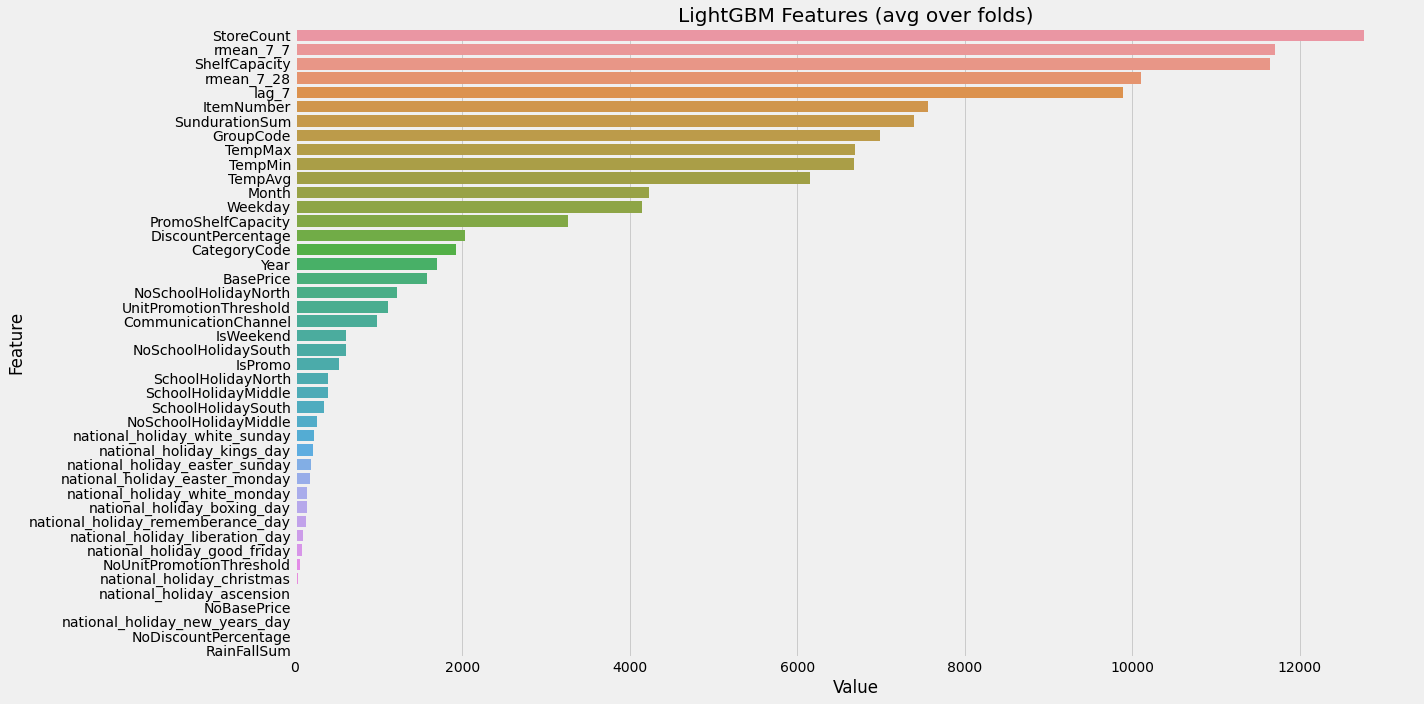

<Figure size 864x360 with 0 Axes>

In [10]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_test.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

The feature importances are quite interesting. We see that the rolling means are quite important features for forecasting. Also the StoreCount and ShelfCapacity should have a direct correlation to the UnitsSold, which makes sesne in this case.

### Perfromance Metric - MAD and MAPE

Let's look at the performance metric. We will use Mean Absolute Deviation (MAD) and Mean Absolute Performance (MAPE) per day as the metrics to measure model performance. MAD is a commonly used forecasting metric. This metric shows how large an error, on average, you have in your forecast. However, as the MAD metric gives you the average error in units, it is not very useful for comparisons. MAPE expresses the forecast error in relation to sales volume. Basically, it tells us by how many percentage points your forecasts are off, on average, but it penalizes slow selling products

In [11]:
# Get predicted value
y_pred = model.predict(X_test)
y_test.reset_index(inplace=True)
y_test['PredictedSales'] = y_pred.tolist()

In [12]:
y_test

,Date,UnitSales,PredictedSales
0,2017-12-24,135.00,49.26
1,2017-12-24,1121.00,656.13
2,2017-12-24,226.00,51.43
3,2017-12-24,606.00,183.52
4,2017-12-24,29.00,18.31
...,...,...,...
923,2017-12-31,18.00,19.72
924,2017-12-31,136.00,61.12
925,2017-12-31,434.00,222.57
926,2017-12-31,1808.00,787.91


In [13]:
y_test_agg = y_test.groupby(['Date'])['UnitSales', 'PredictedSales'].sum().reset_index()
y_test_agg['mape'] = (y_test_agg['PredictedSales'] - y_test_agg['UnitSales'])*100.0/y_test_agg['UnitSales']
y_test_agg['mad'] = (y_test_agg['PredictedSales'] - y_test_agg['UnitSales'])
y_test_agg.set_index('Date', inplace=True)

In [14]:
y_test_agg

,UnitSales,PredictedSales,mape,mad
Date,,,,
2017-12-24,190705.73,72705.46,-61.88,-118000.27
2017-12-25,29100.26,92257.18,217.03,63156.92
2017-12-26,96105.10,106605.69,10.93,10500.59
2017-12-27,195060.36,177081.13,-9.22,-17979.23
2017-12-28,194939.73,200350.44,2.78,5410.71
2017-12-29,241311.10,251066.05,4.04,9754.95
2017-12-30,310916.36,263584.59,-15.22,-47331.77
2017-12-31,162307.36,76477.65,-52.88,-85829.71


<AxesSubplot:xlabel='Date'>

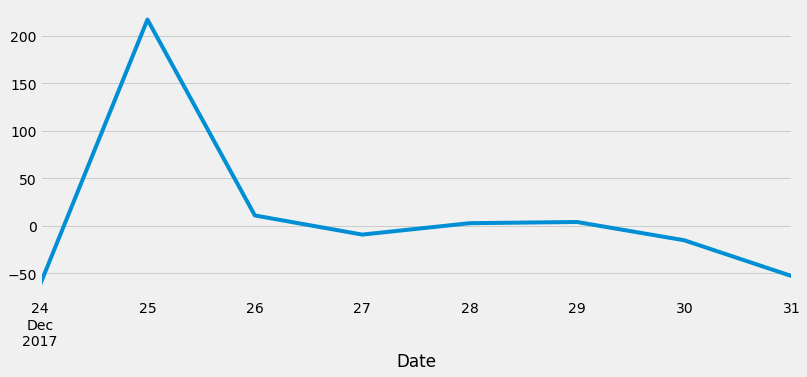

In [15]:
y_test_agg['mape'].plot()

<AxesSubplot:xlabel='Date'>

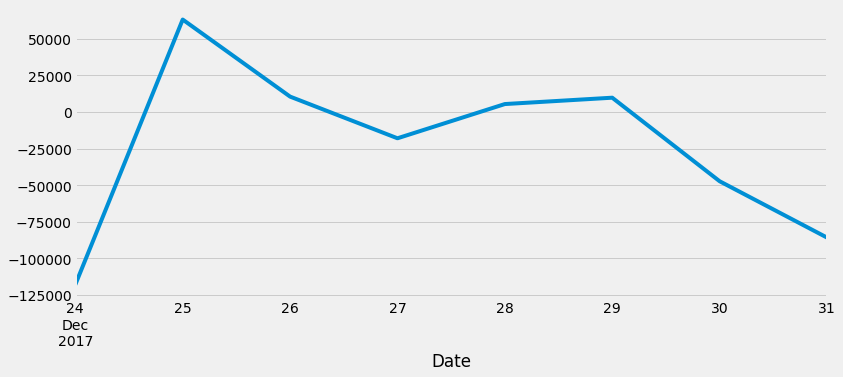

In [16]:
y_test_agg['mad'].plot()

From both the MAPE and MAD we see Dec 24, 25 and Dec 31st have high errors. On Dec 25 stores are closed, whereas on the 24th and 31st they have limited opening hours. Our model is unable to detect these pattern but seems to do ok for the reamining days.

### Naive model - for items that don't partial data for the given timeframe  

The naive model forecasts the UnitSales as the avg value on the given weekday, for the past 4 weeks. This naive model can be easily replaced by other moving average models etc and is for the conceptual purpose mainly. Given that a signficant number of items do not have sales data for the large portions of the time period, it is challenging to build a machine learning model that will forecast these item sales accurately. It is possible to include these items in the previous lgbm model in which case ItemNumber will appear as a key feature. 

If the item does not have data for any particular day, then it will be assumed to have 0 sales. The metrics will be calculated using the last week as test set as done in the earlier ml model.

In [17]:
# read dataframe/
df_naive = pd.read_pickle('../data/df_ma.pkl')

In [18]:
df_naive.head()

,StoreCount,ShelfCapacity,PromoShelfCapacity,UnitPromotionThreshold,IsPromo,national_holiday_new_years_day,national_holiday_good_friday,national_holiday_easter_sunday,national_holiday_easter_monday,national_holiday_kings_day,...,RainFallSum,SundurationSum,CommunicationChannel,ItemNumber,CategoryCode,GroupCode,UnitSales,BasePrice,DiscountPercentage,Date
117567,78,1412.00,0,NaN,False,0,0,0,0,0,...,0.00,1.73,None,11316,7292,5492,217.00,NaN,NaN,2016-01-04
1222391,3,21.00,0,NaN,False,0,0,0,0,0,...,0.00,1.73,None,9246,7292,5612,53.00,NaN,NaN,2016-01-04
1224238,242,2012.00,0,NaN,False,0,0,0,0,0,...,0.00,1.73,None,8902,7289,5596,13.00,NaN,NaN,2016-01-04
1320972,367,2398.00,0,NaN,False,0,0,0,0,0,...,0.00,1.73,None,8214,7289,5617,NaN,NaN,NaN,2016-01-04
1335274,688,1100.00,0,NaN,False,0,0,0,0,0,...,0.00,1.73,None,8779,7289,5545,15.00,NaN,NaN,2016-01-04


In [19]:
def naive_model(df):
    """Computes vag by weekday of laste 4 weeks
       per item
    Args:
        df (pd.DataFrame): Dataframe with sales data.
    Returns:
        pd.DataFrame: With actual and predicted values
    """
    # We only need the Date, ItemNumber and UnitSales columns
    df = df[["Date", "ItemNumber", "UnitSales"]]
    df["weekday"] = df["Date"].dt.weekday
    df_test = df.loc[(df["Date"] >= "2017-12-24") & (df["Date"] <= "2017-12-31")]
    df_4weeks = df.loc[(df["Date"] >= "2017-11-25") & (df["Date"] <= "2017-12-23")]
    df_4weeks.groupby(["weekday", "ItemNumber"])["UnitSales"].mean().reset_index()
    df_forecast = pd.merge(df_test, df_4weeks, on=["ItemNumber", "weekday"], how="left")
    df_forecast.drop(["Date_y", "weekday"], axis=1, inplace=True)
    df_forecast.rename(
        columns={
            "Date_x": "Date",
            "UnitSales_x": "UnitSales",
            "UnitSales_y": "PredictedSales",
        },
        inplace=True,
    )
    
    df_agg = df_forecast.groupby(["Date"]).agg(
        UnitSalesTotal=("UnitSales", "sum"),
        PredictedSalesTotal=("PredictedSales", "sum"),
    ).reset_index()

    df_agg.rename(
        columns={
            "UnitSalesTotal": "UnitSales",
            "PredictedSalesTotal": "PredictedSales",
        },
        inplace=True,
    )

    return df_agg

In [20]:
df_naive_fc = naive_model(df_naive)

In [21]:
df_naive_fc

,Date,UnitSales,PredictedSales
0,2017-12-24,157127.00,103267.00
1,2017-12-25,16692.00,157104.00
2,2017-12-26,70291.00,155489.00
3,2017-12-27,128346.00,174189.00
4,2017-12-28,129100.00,180230.00
5,2017-12-29,165440.00,257809.00
6,2017-12-30,280250.00,348697.00
7,2017-12-31,122450.00,103650.00


In [22]:
# let's calculate mape and mad for the naive model
df_naive_fc['mape'] = (df_naive_fc['UnitSales'] - df_naive_fc['PredictedSales'])*100.0/df_naive_fc['UnitSales']
df_naive_fc['mad'] = (df_naive_fc['UnitSales'] - df_naive_fc['PredictedSales'])

In [23]:
df_naive_fc.set_index('Date', inplace=True)

In [24]:
df_naive_fc

,UnitSales,PredictedSales,mape,mad
Date,,,,
2017-12-24,157127.00,103267.00,34.28,53860.00
2017-12-25,16692.00,157104.00,-841.19,-140412.00
2017-12-26,70291.00,155489.00,-121.21,-85198.00
2017-12-27,128346.00,174189.00,-35.72,-45843.00
2017-12-28,129100.00,180230.00,-39.60,-51130.00
2017-12-29,165440.00,257809.00,-55.83,-92369.00
2017-12-30,280250.00,348697.00,-24.42,-68447.00
2017-12-31,122450.00,103650.00,15.35,18800.00


<AxesSubplot:xlabel='Date'>

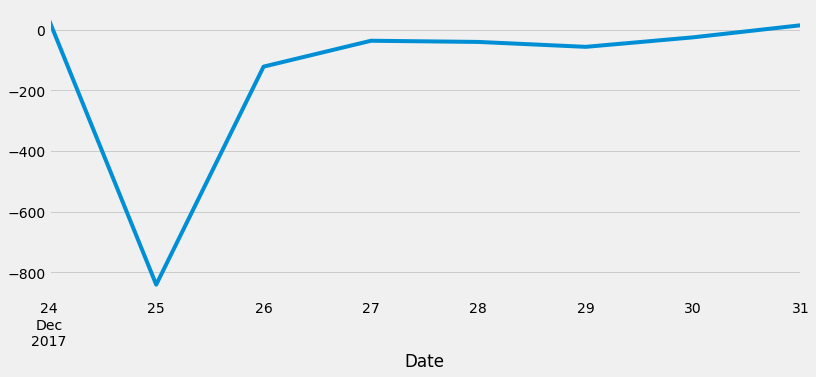

In [25]:
df_naive_fc['mape'].plot()

<AxesSubplot:xlabel='Date'>

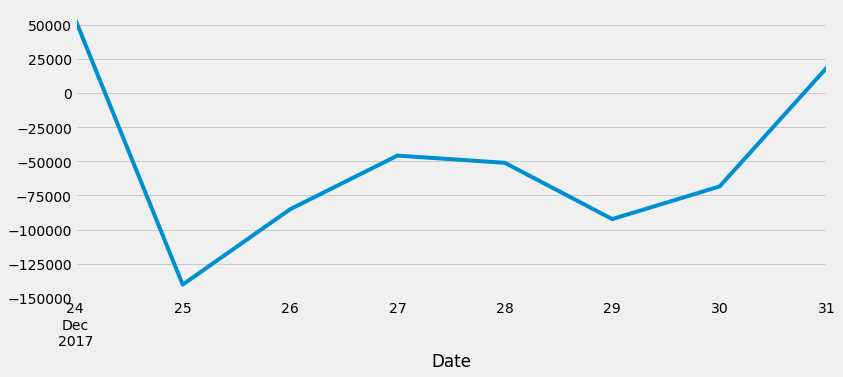

In [26]:
df_naive_fc['mad'].plot()

Similar to the lightgbm model we see the errors to be high Dec 24, 25 and 31st. Dec 25 with store closings, there is always going to be very hioght errors as the last 4 weeks would have normal sales.

### Conclusion

This exercise demonstrates the solution to this forecasting problem using a naive model and a lightgbm model. The dataset is quite challening as there are many items with missing/unavailable sales data. This could be because the items are seasonal or have been discontinued. In the presentation, I will provide more detialed explanation of my approach as well as how I would productionize such a model.